# Causal reasoning in dynamical systems

In [2]:
%reload_ext autoreload
%autoreload 2

import pyro
import torch
from pyro.infer.autoguide import AutoMultivariateNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from pyro.infer import Predictive

from chirho.counterfactual.handlers import TwinWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.observational.handlers import condition

from chirho.dynamical.handlers import (
    StaticObservation,
    StaticIntervention,
    LogTrajectory,
    DynamicIntervention,
    InterruptionEventLoop,
    StaticBatchObservation,
)
from chirho.dynamical.ops import State, simulate, Dynamics

from chirho.dynamical.handlers.solver import TorchDiffEq

from chirho.observational.handlers.soft_conditioning import (
    AutoSoftConditioning
)

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

## Define our SIR model

In [3]:
class SimpleSIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    @pyro.nn.pyro_method
    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]) -> None:
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]

    @pyro.nn.pyro_method
    def observation(self, X: State[torch.Tensor]) -> None:
        # We don't observe the number of susceptible individuals directly, and instead can only infer it from the
        #  number of test kits that are sold (which is a noisy function of the number of susceptible individuals).
        event_dim = 1 if X["I"].shape and X["I"].shape[-1] > 1 else 0
        pyro.sample("test_kit_sales", dist.Normal(torch.log(torch.relu(X["S"]) + 1), 1).to_event(event_dim))
        pyro.sample("I_obs", dist.Poisson(X["I"]).to_event(event_dim))  # noisy number of infected actually observed
        pyro.sample("R_obs", dist.Poisson(X["R"]).to_event(event_dim))  # noisy number of recovered actually observed

    def forward(self, X: State[torch.Tensor]):
        dX = State()
        self.diff(dX, X)
        return dX

## Generate synthetic data from the SIR model

In [4]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = State(S=torch.tensor(99.0), I=torch.tensor(1.0), R=torch.tensor(0.0))
start_time = torch.tensor(0.0)
end_time = torch.tensor(3.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time+step_size, end_time, step_size)

# We now simulate from the SIR model
beta_true = torch.tensor(0.05)
gamma_true = torch.tensor(0.5)
sir_true = SimpleSIRDynamics(beta_true, gamma_true)
with LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time, solver=TorchDiffEq())

sir_true_traj = lt.trajectory

### Simulate the latent trajectories of the ODE model

/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

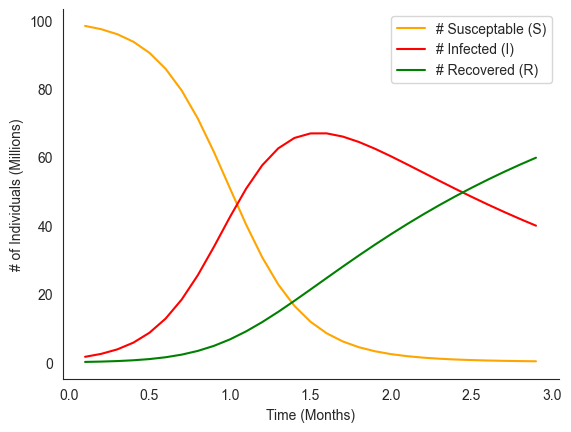

In [5]:
sns.lineplot(
    x=logging_times, y=sir_true_traj["S"], label="# Susceptable (S)", color="orange"
)
sns.lineplot(x=logging_times, y=sir_true_traj["I"], label="# Infected (I)", color="red")
sns.lineplot(x=logging_times, y=sir_true_traj["R"], label="# Recovered (R)", color="green")
sns.despine()
plt.xlabel("Time (Months)")
plt.ylabel("# of Individuals (Millions)")
plt.legend()

### Add noise to state trajectories to generate observations
 

In [6]:
obs_start_time = torch.tensor(0.5) # Measurements start 0.5 month into the pandemic
obs_end_time = torch.tensor(1.) # Measurements end 1 month into the pandemic
obs_sample_rate = torch.tensor(1/30) # Take measurements one per day
obs_logging_times = torch.arange(obs_start_time, obs_end_time, obs_sample_rate)
N_obs = obs_logging_times.shape[0]
with LogTrajectory(obs_logging_times) as lt_obs:
    simulate(sir_true, init_state, start_time, end_time, solver=TorchDiffEq())

sir_obs_traj = lt_obs.trajectory
with pyro.poutine.trace() as tr:
    sir_true.observation(sir_obs_traj)

sir_data = State(**{k:tr.trace.nodes[k]["value"] for k in ["test_kit_sales", "I_obs", "R_obs"]})

/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

Text(0, 0.5, 'Observed # Recovered (Millions)')

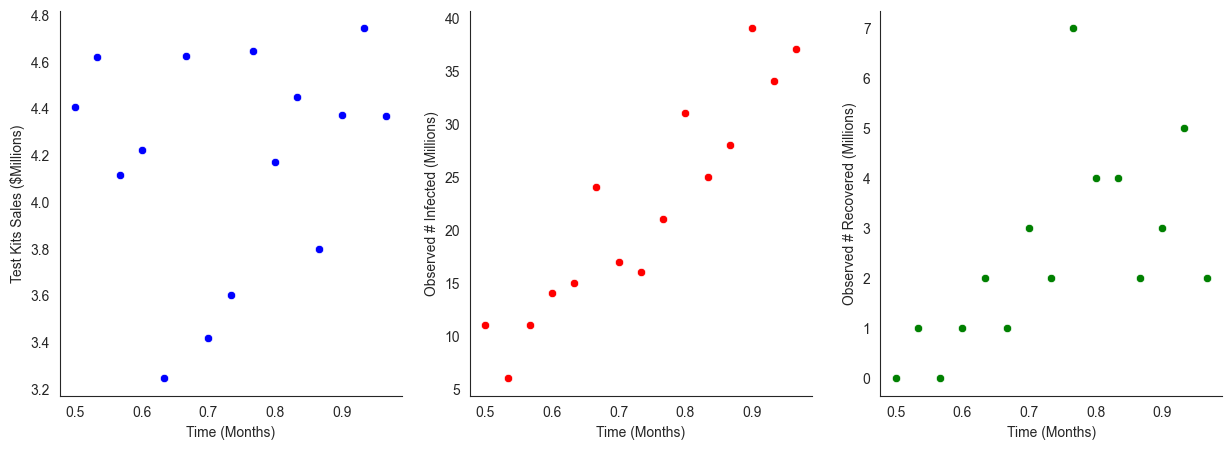

In [7]:
# Plot observed data
fix, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot test kit sales
sns.scatterplot(x=obs_logging_times, y=sir_data["test_kit_sales"], color="blue", ax=ax[0])
sns.despine()
ax[0].set_xlabel("Time (Months)")
ax[0].set_ylabel("Test Kits Sales ($Millions)")

# Plot observed infected
sns.scatterplot(x=obs_logging_times, y=sir_data["I_obs"], color="red", ax=ax[1])
sns.despine()
ax[1].set_xlabel("Time (Months)")
ax[1].set_ylabel("Observed # Infected (Millions)")

# Plot observed recovered
sns.scatterplot(x=obs_logging_times, y=sir_data["R_obs"], color="green", ax=ax[2])
sns.despine()
ax[2].set_xlabel("Time (Months)")
ax[2].set_ylabel("Observed # Recovered (Millions)")

## Extend our model to include uncertainty over model parameters

In [8]:
# We place uniform priors on the beta and gamma parameters defining the SIR model
def bayesian_sir(base_model=SimpleSIRDynamics) -> Dynamics[torch.Tensor]:
    beta = pyro.sample("beta", dist.Uniform(0, 1))
    gamma = pyro.sample("gamma", dist.Uniform(0, 1))
    sir = base_model(beta, gamma)
    return sir


def simulated_bayesian_sir(init_state, start_time, logging_times, base_model=SimpleSIRDynamics) -> State[torch.Tensor]:
    sir = bayesian_sir(base_model)
    with LogTrajectory(logging_times) as lt:
        simulate(sir, init_state, start_time, logging_times[-1], solver=TorchDiffEq())
    trajectory = lt.trajectory
    # This is a small trick to make the solution variables available to pyro
    [pyro.deterministic(k, trajectory[k]) for k in trajectory.keys()]
    return trajectory


def conditioned_sir(obs_times, data, init_state, start_time, end_time, base_model=SimpleSIRDynamics) -> None:
    sir = bayesian_sir(base_model)
    obs = condition(data=data)(sir.observation)
    with StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, end_time, solver=TorchDiffEq())

## Perform Inference!

In [9]:
# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(model, n_steps=100, verbose=True, lr=.03, vi_family=AutoMultivariateNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 100 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [10]:
# Run inference to approximate the posterior distribution of the SIR model parameters
sir_guide = run_svi_inference(
    conditioned_sir,
    n_steps=200,
    obs_times=obs_logging_times,
    data=sir_data,
    init_state=init_state,
    start_time=start_time,
    end_time=end_time,
)

[iteration 0001] loss: 919.1129
[iteration 0100] loss: 111.1926
[iteration 0200] loss: 88.2056


## Evaluate the performance of our inference

In [11]:
# Generate samples from the posterior predictive distribution
sir_predictive = Predictive(simulated_bayesian_sir, guide=sir_guide, num_samples=100)
sir_posterior_samples = sir_predictive(init_state, logging_times)

### First, we compare the approximate posterior distribution with the true beta and gamma parameters generating the data

/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

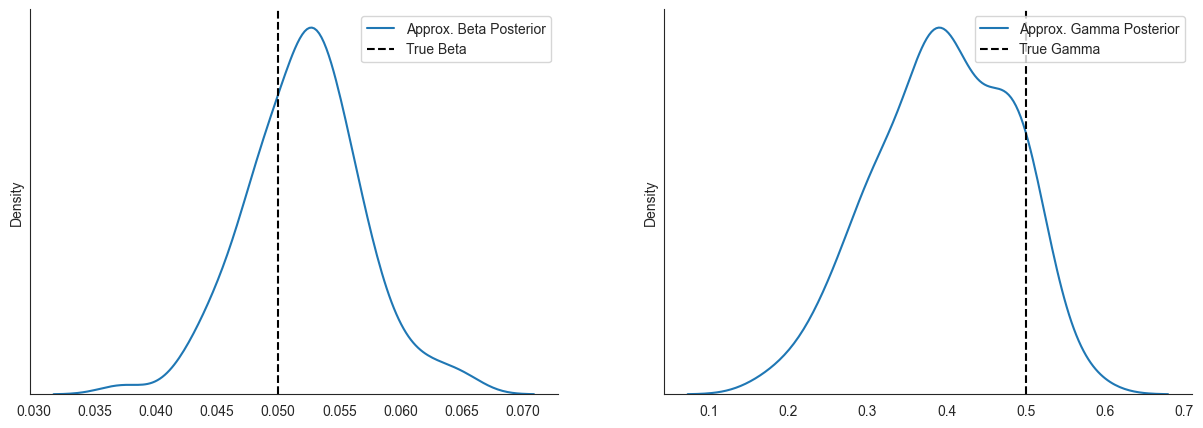

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(sir_posterior_samples["beta"], label="Approx. Beta Posterior", ax=ax[0])
ax[0].axvline(beta_true, color="black", label="True Beta", linestyle="--")
sns.despine()
ax[0].set_yticks([])
ax[0].legend(loc="upper right")

sns.kdeplot(sir_posterior_samples["gamma"], label="Approx. Gamma Posterior", ax=ax[1])
plt.axvline(gamma_true, color="black", label="True Gamma", linestyle="--")
sns.despine()
ax[1].set_yticks([])
ax[1].legend(loc="upper right")

### Next, we compare the predictive performance on the held out period between $t=1$ and $t=3$ years

In [13]:
def SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax):
    sns.lineplot(
        x=time_period,
        y=state_pred.mean(dim=0),
        color=color,
        label="Posterior Mean",
        ax=ax,
    )
    # 90% Credible Interval
    ax.fill_between(
        time_period,
        torch.quantile(state_pred, 0.05, dim=0),
        torch.quantile(state_pred, 0.95, dim=0),
        alpha=0.2,
        color=color,
    )

    ax.set_xlabel("Time (Yrs)")
    ax.set_ylabel(ylabel)


def SIR_data_plot(time_period, data, data_label, ax):
    sns.lineplot(
        x=time_period, y=data, color="black", ax=ax, linestyle="--", label=data_label
    )


def SIR_test_plot(test_time, ax):
    ax.axvline(
        test_time, color="black", linestyle="dotted", label="Start of Testing Period"
    )


def SIR_plot(
    time_period,
    test_time,
    state_pred,
    data,
    ylabel,
    color,
    data_label,
    ax,
    legend=False,
    test_plot=True,
):
    SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax)
    SIR_data_plot(time_period, data, data_label, ax)
    if test_plot:
        SIR_test_plot(test_time, ax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()
    sns.despine()

ValueError: All arrays must be of the same length

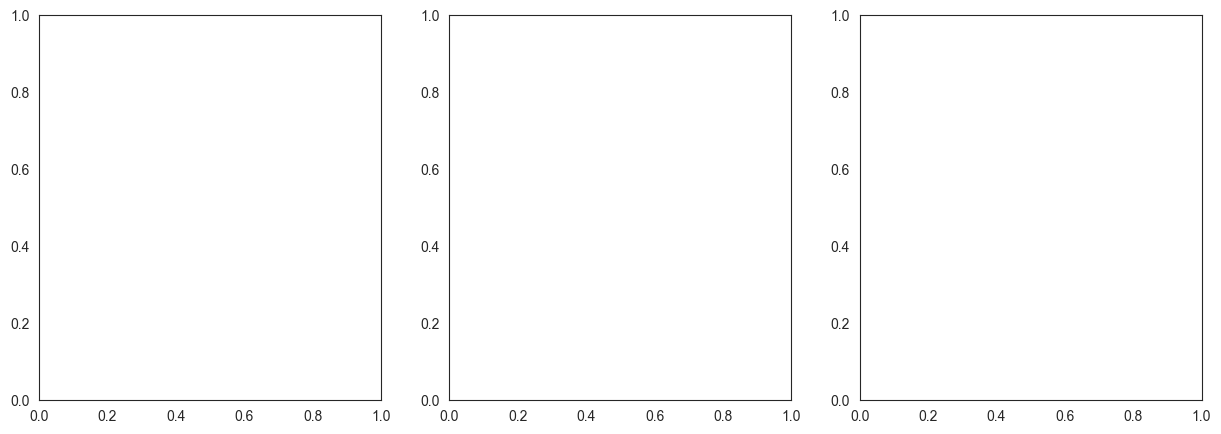

In [14]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    1,
    sir_posterior_samples["S"],
    sir_true_traj["S"],
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
)
SIR_plot(
    logging_times,
    1,
    sir_posterior_samples["I"],
    sir_true_traj["I"],
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
)
SIR_plot(
    logging_times,
    1,
    sir_posterior_samples["R"],
    sir_true_traj["R"],
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
)

## Let's explore how different interventions might flatten the infection curve

Suppose the government can enact different lockdown measures (of varying strength) to flatten the infection curve. Following [2], we define the stength of lockdown measure at time $t$ by $l_t \in [0, 1]$ for $1 \leq t \leq T$. Parametrize the transmission rate $\beta_t$ as:

$$
\beta_t = (1 - l_t) \beta_0,
$$

where $\beta_0$ denotes the unmitigated transmission rate and larger values of $l_t$ correspond to stronger lockdown measures. Then, the time-varying SIR model is defined as follows:

$$
\begin{split}
    dS_t &= -\beta_t S_t I_t \\
    dI_t &= \beta_t S_t I_t - \gamma I_t \\
    dR_t &= \gamma I_t
\end{split}
$$

where $S_t, I_t, R_t$ denote the number of susceptable, infected, and recovered individuals at time $t$ for $1 \leq t \leq T$.

### We can implement this new model compositionally using our existing SIR model implementation.

In [ ]:
class SimpleSIRDynamicsLockdown(SimpleSIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(beta0, gamma)
        self.beta0 = beta0

    @pyro.nn.pyro_method
    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        self.beta = (1 - X["l"]) * self.beta0  # time-varing beta parametrized by lockdown strength l_t
        dX["l"] = torch.tensor(0.0)
        # Call the base SIR class diff method
        super().diff(dX, X)


init_state_lockdown = State(
    S=torch.tensor(99.0), 
    I=torch.tensor(1.0), 
    R=torch.tensor(0.0), 
    l=torch.tensor(0.0)
)

### Let's first look at a deterministic intervention where the transmission rate is reduced by 75% between $t=1$ and $t=2$ due to stronger lockdown measures. We see in the figure below that this lockdown measures indeed "flattens" the curve.

In [15]:
def intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state, logging_times) -> State[torch.Tensor]:
    sir = bayesian_sir(SimpleSIRDynamicsLockdown)
    with LogTrajectory(logging_times) as lt:
        with InterruptionEventLoop():
            with StaticIntervention(time=torch.as_tensor(lockdown_start), intervention=State(l=torch.as_tensor(lockdown_strength))):
                with StaticIntervention(time=torch.as_tensor(lockdown_end), intervention=State(l=torch.tensor(0.0))):
                    simulate(sir, init_state, logging_times[0], logging_times[-1] + 1e-3, solver=TorchDiffEq())
                    
    trajectory = lt.trajectory
    # This is a small trick to make the solution variables available to pyro
    [pyro.deterministic(k, trajectory[k]) for k in trajectory.keys()]
    return trajectory

In [16]:
lockdown_start = 1.01
lockdown_end = 2.0
lockdown_strength = 0.75

true_intervened_sir = pyro.condition(intervened_sir, data={"beta": beta_true, "gamma": gamma_true})
true_intervened_trajectory = true_intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state_lockdown, logging_times)

intervened_sir_predictive = Predictive(intervened_sir, guide=sir_guide, num_samples=100)
intervened_sir_posterior_samples = intervened_sir_predictive(lockdown_start, lockdown_end, lockdown_strength, init_state_lockdown, logging_times)

NameError: name 'init_state_lockdown' is not defined

NameError: name 'intervened_sir_posterior_samples' is not defined

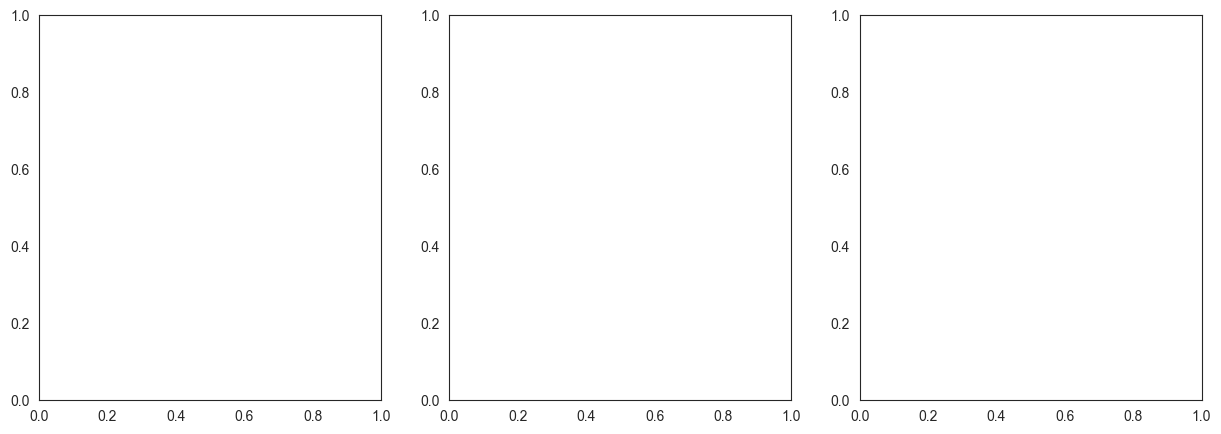

In [17]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    1,
    intervened_sir_posterior_samples["S"],
    true_intervened_trajectory["S"],
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    intervened_sir_posterior_samples["I"],
    true_intervened_trajectory["I"],
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    intervened_sir_posterior_samples["R"],
    true_intervened_trajectory["R"],
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Plot the static intervention
for a in ax:
    a.axvline(lockdown_start, color="grey", linestyle="-", label="Start of Lockdown")
    a.axvline(lockdown_end, color="grey", linestyle="-", label="Start of Lockdown")

## What if we're uncertain about when the lockdown will happen?

In [18]:
def uncertain_intervened_sir(lockdown_strength, init_state, logging_times) -> State:
    lockdown_start = pyro.sample("lockdown_start", dist.Uniform(0.5, 1.5))
    lockdown_end = pyro.sample("lockdown_end", dist.Uniform(1.5, 2.5))
    return intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state, logging_times)

In [19]:
uncertain_intervened_sir_predictive = Predictive(uncertain_intervened_sir, guide=sir_guide, num_samples=100)
uncertain_intervened_sir_posterior_samples = uncertain_intervened_sir_predictive(lockdown_strength, init_state_lockdown, logging_times)

/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

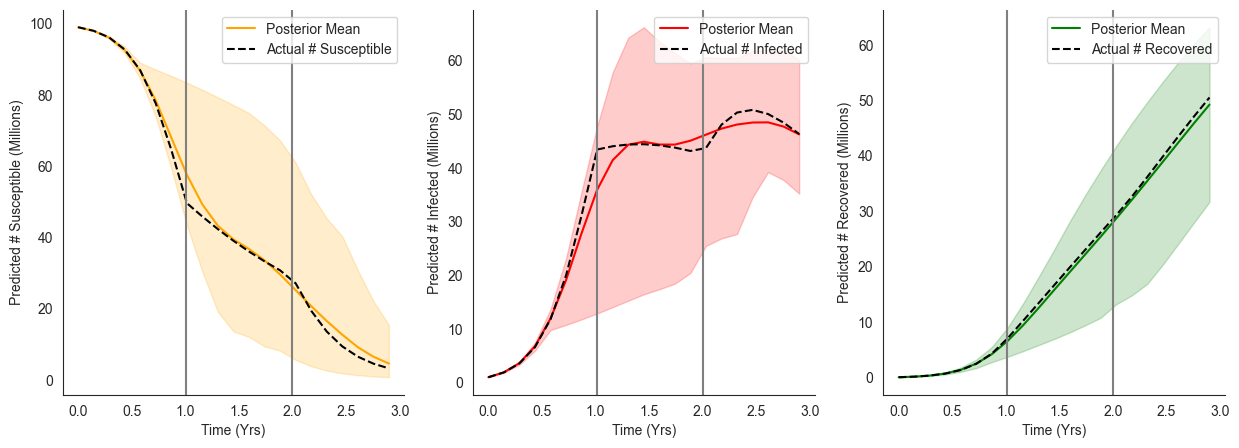

In [20]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    1,
    uncertain_intervened_sir_posterior_samples["S"],
    true_intervened_trajectory["S"],
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    uncertain_intervened_sir_posterior_samples["I"],
    true_intervened_trajectory["I"],
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    uncertain_intervened_sir_posterior_samples["R"],
    true_intervened_trajectory["R"],
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Plot the static intervention
for a in ax:
    a.axvline(lockdown_start, color="grey", linestyle="-", label="Start of Lockdown")
    a.axvline(lockdown_end, color="grey", linestyle="-", label="Start of Lockdown")

## Next, let's consider a state-dependent intervention ("dynamic intervention")

### Here we assume that the government will issue a lockdown measure that reduces the transmission rate by 90% whenever the number of infected people hits 30 million infected. The government removes this lockdown when 20% of the population is recovered.

In [21]:
def government_lockdown_policy(target_state: State[torch.tensor]):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return state["I"] - target_state["I"]

    return event_f


def government_lift_policy(target_state: State[torch.tensor]):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return target_state["R"] - state["R"]

    return event_f


def dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state, logging_times) -> State:
    sir = bayesian_sir(SimpleSIRDynamicsLockdown)
    with LogTrajectory(logging_times) as lt:
        with InterruptionEventLoop():
            with DynamicIntervention(event_f=government_lockdown_policy(lockdown_trigger), intervention=State(l=torch.as_tensor(lockdown_strength))):
                with DynamicIntervention(event_f=government_lift_policy(lockdown_lift_trigger), intervention=State(l=torch.tensor(0.0))):
                    simulate(sir, init_state, logging_times[0], logging_times[-1] + 1e-3, solver=TorchDiffEq())
    trajectory = lt.trajectory
    
    # This is a small trick to make the solution variables available to pyro
    [pyro.deterministic(k, trajectory[k]) for k in trajectory.keys()]
    return trajectory

In [22]:
lockdown_trigger = State(I=torch.tensor(30.0))
lockdown_lift_trigger = State(R=torch.tensor(20.0))
lockdown_strength = 0.9  # reduces transmission rate by 90%

true_dynamic_intervened_sir = pyro.condition(dynamic_intervened_sir, data={"beta": beta_true, "gamma": gamma_true})
true_dynamic_intervened_trajectory = true_dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state_lockdown, logging_times)

dynamic_intervened_sir_predictive = Predictive(dynamic_intervened_sir, guide=sir_guide, num_samples=100)
dynamic_intervened_sir_posterior_samples = dynamic_intervened_sir_predictive(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state_lockdown, logging_times)

/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

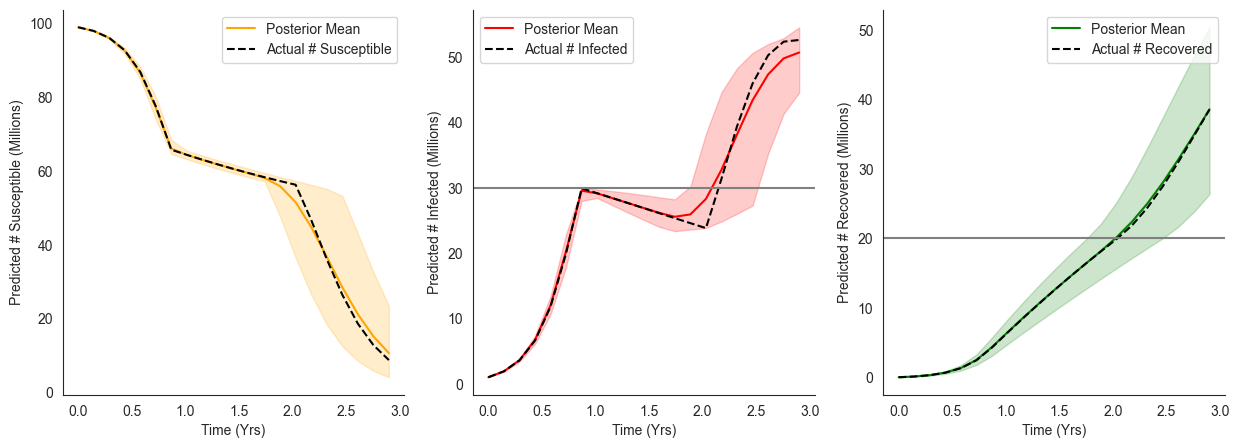

In [23]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    1,
    dynamic_intervened_sir_posterior_samples["S"],
    true_dynamic_intervened_trajectory["S"],
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    dynamic_intervened_sir_posterior_samples["I"],
    true_dynamic_intervened_trajectory["I"],
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    dynamic_intervened_sir_posterior_samples["R"],
    true_dynamic_intervened_trajectory["R"],
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Draw horizontal line at lockdown trigger
ax[1].axhline(lockdown_trigger["I"], color="grey", linestyle="-")
ax[2].axhline(lockdown_lift_trigger["R"], color="grey", linestyle="-")

## Again, we can represent uncertainty about the interventions themselves.

In [24]:
def uncertain_dynamic_intervened_sir(lockdown_strength, init_state, logging_times) -> State:
    lockdown_trigger = State(I=pyro.sample("lockdown_trigger", dist.Uniform(30.0, 40.0)))
    lockdown_lift_trigger = State(R=pyro.sample("lockdown_lift_trigger", dist.Uniform(20.0, 30.0)))
    return dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state, logging_times)

In [25]:
uncertain_dynamic_intervened_sir_predictive = Predictive(uncertain_dynamic_intervened_sir, guide=sir_guide, num_samples=100)
uncertain_dynamic_intervened_sir_posterior_samples = (uncertain_dynamic_intervened_sir_predictive(lockdown_strength, init_state_lockdown, logging_times))

/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

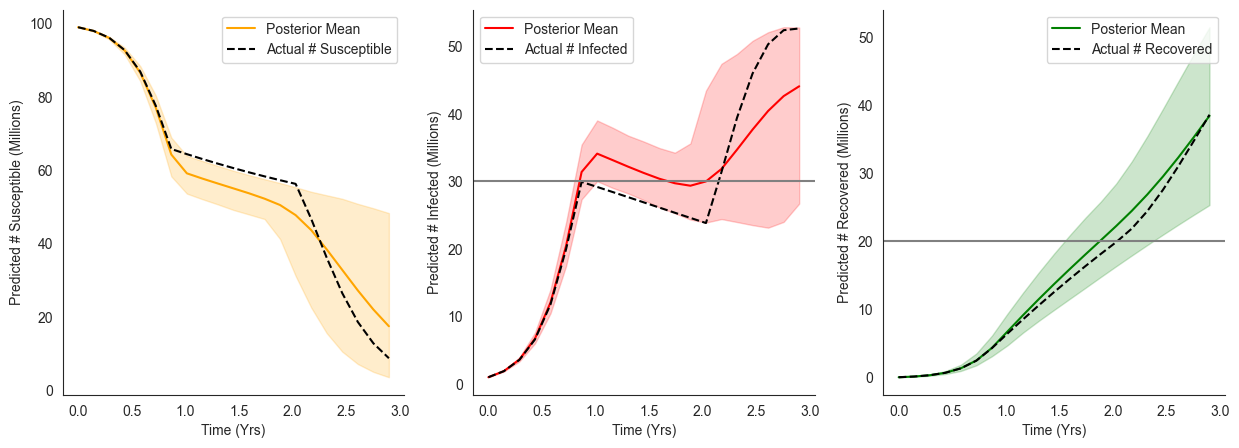

In [26]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    1,
    uncertain_dynamic_intervened_sir_posterior_samples["S"],
    true_dynamic_intervened_trajectory["S"],
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    uncertain_dynamic_intervened_sir_posterior_samples["I"],
    true_dynamic_intervened_trajectory["I"],
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    uncertain_dynamic_intervened_sir_posterior_samples["R"],
    true_dynamic_intervened_trajectory["R"],
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Draw horizontal line at lockdown trigger
ax[1].axhline(lockdown_trigger["I"], color="grey", linestyle="-")
ax[2].axhline(lockdown_lift_trigger["R"], color="grey", linestyle="-")

## Modeling a superspreader event using counterfactual inference

Suppose at time $t=0.3$ (`superspreader_time`), there is a superspreader event that results in a rapid infection a large number of people that would have otherwise remained susceptible. We model this as an instantaneous infection of 15 million people (`superspreader_delta`). One month later, suppose that a plane entering a foreign country holds 4 infected individuals (`landing_data`). We would like to answer the following counterfactual questions: if the superspreader event never occured, how many infected people would be on the plane?

Counterfactuals become interesting when noise is plausibly shared between the factual and counterfactual worlds. Our noise model for the number of infected passengers comprises two sources of noise: one that we assume is shared between the factual and counterfactual regimes, and another that is not. This latter noise encapsulates an aggregation of unknowns that may differ across the factual and counterfactual regimes. The former, however, stems from the precision of a specific infection-screening machine used by the airline to deny boarding to infected would-be passengers. This machine was built before the superspreader event, and we assume its performance is the same across factual and counterfactual worlds.

In [27]:
# This allows us to specify non-continuous dynamics that won't be affected by e.g. counterfactual handlers.
class NonContinuousDynamics(StaticIntervention):
    def _pyro_apply_interruptions(self, msg) -> None:
        with pyro.poutine.block(hide_types=["intervene"]):
            super()._pyro_apply_interruptions(msg)

In [28]:
ss_time = logging_times[torch.searchsorted(logging_times, .25)]
print("Superspreader Time", ss_time)

Superspreader Time tensor(0.2900)


In [29]:
landing_time = ss_time + 4/52 + 1e-4
landing_data = {"infected_passengers": torch.tensor(4.)}

# Because counterfactuals assume the intervened state is the counterfactual world, we have to hackily invert
# this by treating the superspreader event as factual non-continuous dynamics, and the counterfactual as an
# inversion of superspreader infections immediately following the superspreader event.

superspreader_delta = torch.tensor(15.)

# HACK counterfactual inverts the factual intervention slightly afterward.
inverse_superspreader_intervention = State(
    S=lambda s: s + superspreader_delta,
    I=lambda i: i - superspreader_delta,
)
inverse_superspreader_time = ss_time + 2e-3

superspreader_intervention = State(
    # The superspreader event instantaneously subtracts from the susceptible group and adds to the
    # infected group.
    S=lambda s: s - superspreader_delta,
    I=lambda i: i + superspreader_delta,
)
superspreader_time = inverse_superspreader_time - 1e-3

superspreader_intervention = NonContinuousDynamics(
    time=superspreader_time, 
    intervention=superspreader_intervention
)

inverse_superspreader_intervention = StaticIntervention(
    time=inverse_superspreader_time, 
    intervention=inverse_superspreader_intervention
)


def get_num_infected_passengers(num_infected_in_millions: torch.Tensor, c=2.):
    # Our model assumes that a given set of passengers on a plane are derived by drawing c passengers
    # randomly from each million people in the country of origin.
    number_of_individuals_infected = num_infected_in_millions * 1e6
    return c * 1e-6 * number_of_individuals_infected


class PlaneSuperSpreaderSIR(SimpleSIRDynamics):
    def observation(self, X: State[torch.Tensor]):
        if X["I"].shape and X["I"].shape[-1] > 1:
            super().observation(X)
        else:
            # An airline builds screening machines that detect infections in passengers. If
            # passengers are infected, they are denied boarding. These screening machines were built
            # before the super-spreader event, so their effectiveness (modeled as 0-1 accuracy rate) is
            # the same between the factual and counterfactual worlds. 
            
            enittb = expected_num_infected_trying_to_board = get_num_infected_passengers(X["I"])
            # The number trying to board is subject to noise we do not assume is shared between worlds.
            num_infected_trying_to_board = pyro.sample("nittb", dist.Normal(enittb, 1.0))
            
            # The screening machines have some effectiveness rate that is shared between worlds.
            # This is a value between 0 and 1.
            se_frate = torch.sigmoid(pyro.sample("u_ip", dist.Normal(0., 2.)))
            
            infected_passengers = se_frate * num_infected_trying_to_board
            pyro.deterministic("infected_passengers", infected_passengers, event_dim=0)
            
            # The arrival country has 100% accurate tests and test all passengers on arrival, hence the
            # ability to observe number of infected passengers directly.


def conditioned_sir_reparam(obs_times, data, init_state, logging_times, base_model=PlaneSuperSpreaderSIR) -> None:
    sir = bayesian_sir(base_model)
    batch_obs = condition(data=data)(sir.observation)
    landing_obs = condition(data=landing_data)(sir.observation)
    reparam_config = AutoSoftConditioning(scale=.1, alpha=0.5)
    with InterruptionEventLoop():
        with pyro.poutine.reparam(config=reparam_config):
            with StaticObservation(landing_time, observation=landing_obs):
                with StaticBatchObservation(obs_times, observation=batch_obs):
                    with superspreader_intervention:
                        simulate(sir, init_state, logging_times[0], logging_times[-1] + 1e-3, solver=TorchDiffEq())


def counterfactual_sir(obs_times, data, init_state, logging_times) -> State:
    sir = bayesian_sir(PlaneSuperSpreaderSIR)
    batch_obs = condition(data=data)(sir.observation)
    landing_obs = condition(data=landing_data)(sir.observation)
    with LogTrajectory(logging_times) as lt:
        with InterruptionEventLoop():
            with StaticObservation(time=landing_time, observation=landing_obs):
                with superspreader_intervention:
                    with StaticBatchObservation(obs_times, observation=batch_obs):
                        with TwinWorldCounterfactual() as cf:
                            with inverse_superspreader_intervention:
                                simulate(sir, init_state, logging_times[0], logging_times[-1] + 1e-3, solver=TorchDiffEq())
    trajectory = lt.trajectory
    with cf:
        factual_indices = IndexSet(
        **{k: {0} for k in indices_of(trajectory, event_dim=1).keys()}
        )

        cf_indices = IndexSet(
            **{k: {1} for k in indices_of(trajectory, event_dim=1).keys()}
        )
       
        factual_traj = gather(trajectory, factual_indices, event_dim=1)
        cf_traj = gather(trajectory, cf_indices, event_dim=1)
        
        # This is a small trick to make the trajectory variables available to pyro    
        for k in trajectory.keys():
            pyro.deterministic(k + '_factual', factual_traj[k])
            pyro.deterministic(k + '_cf', cf_traj[k])

In [30]:

with InterruptionEventLoop():
    with superspreader_intervention:
        num_infected_in_millions = simulate(sir_true, init_state, torch.tensor(0), landing_time, solver=TorchDiffEq())["I"].item()
        expected_num_infected_passengers = get_num_infected_passengers(num_infected_in_millions)
        print("Expected Number of infected people trying to board in superspreader reality: X.I =",
              round(num_infected_in_millions, 2), "Million")
        expected_actual_screening_rate = landing_data['infected_passengers'] / expected_num_infected_passengers
        print("Expected Screening Failure Rate =", round(expected_actual_screening_rate.item(), 2))
        print("Expected u_ip", round(torch.logit(expected_actual_screening_rate).item(), 2))
        print('True # Infected Passengers Factual = ', landing_data['infected_passengers'].item())

with InterruptionEventLoop():
    with superspreader_intervention:
        with inverse_superspreader_intervention:
            num_infected_in_millions = round(simulate(sir_true, init_state, torch.tensor(0), landing_time, solver=TorchDiffEq())["I"].item(), 2)
            expected_num_infected_passengers = get_num_infected_passengers(num_infected_in_millions)
            print("Number of infected people trying to board in counterfactual reality: X.I =",
                  num_infected_in_millions, "Million")
            true_cf_infected = expected_num_infected_passengers * expected_actual_screening_rate
            print("True # Infected Passengers Counterfactual = ", round(true_cf_infected.item(), 2))

Expected Number of infected people trying to board in superspreader reality: X.I = 24.08 Million
Expected Screening Failure Rate = 0.08
Expected u_ip -2.4
True # Infected Passengers Factual =  4.0
Number of infected people trying to board in counterfactual reality: X.I = 5.04 Million
True # Infected Passengers Counterfactual =  0.84


In [31]:
class CFGuide(pyro.nn.PyroModule):
    """
    A guide modeling the conditional distribution of noise on latent dynamic parameters as a normal
     with parameters defined as a linear combination of functions of those latent parameters.
    """

    def __init__(self, original_sir_guide, noise_name: str):
        super().__init__()
        self.original_sir_guide = original_sir_guide
        self.noise_name = noise_name

    @pyro.nn.PyroParam(constraint=dist.constraints.positive)
    def noise_std_coefficients(self):
        return torch.ones(4)

    @pyro.nn.PyroParam()
    def noise_mean_coefficients(self):
        return torch.ones(4)

    def forward(self, *args, **kwargs):
        self.original_sir_guide.requires_grad_(False)

        bgd = self.original_sir_guide()
        beta = bgd['beta']
        gamma = bgd['gamma']

        noise_mean = self.noise_mean_coefficients @ torch.tensor([beta, gamma, beta * gamma, 1.])
        noise_std = self.noise_std_coefficients @ torch.tensor([beta, gamma, beta * gamma, 1.])

        noise = pyro.sample(self.noise_name, dist.Normal(noise_mean, noise_std))
        return noise

cf_guide = CFGuide(original_sir_guide=sir_guide, noise_name='u_ip_0.36702409386634827')

In [32]:
# Approx. posterior over latent SIR params and noise variables conditional 
# on observed data.
sir_guide_reparam = run_svi_inference(
    conditioned_sir_reparam,
    n_steps=500,
    obs_times=obs_logging_times,
    data=sir_data,
    init_state=init_state,
    logging_times=torch.tensor([0.0, 3.0]),
    guide=cf_guide,
)

/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'nittb_0.36702409386634827'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


[iteration 0001] loss: 58092.1367
[iteration 0100] loss: 20789.3926
[iteration 0200] loss: 916.2467
[iteration 0300] loss: 859.0110
[iteration 0400] loss: 890.1702
[iteration 0500] loss: 838.2838


In [33]:
# Compute counterfactual
cf_sir_predictive = Predictive(counterfactual_sir,
    guide=sir_guide_reparam, num_samples=100
)

cf_sir_posterior_samples = cf_sir_predictive(
    obs_logging_times, sir_data, init_state, logging_times
)

In [34]:
def SIR_cf_uncertainty_plot(logging_times, state_pred, line_label, ylabel, color, ax):
    sns.lineplot(
        x=logging_times,
        y=state_pred.mean(dim=0),
        color=color,
        label=f"Posterior Mean: {line_label}",
        ax=ax,
    )
    # 90% Credible Interval
    ax.fill_between(
        logging_times,
        torch.quantile(state_pred, 0.05, dim=0),
        torch.quantile(state_pred, 0.95, dim=0),
        alpha=0.2,
        color=color,
    )

    ax.set_xlabel("Time (Yrs)")
    ax.set_ylabel(ylabel)

/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

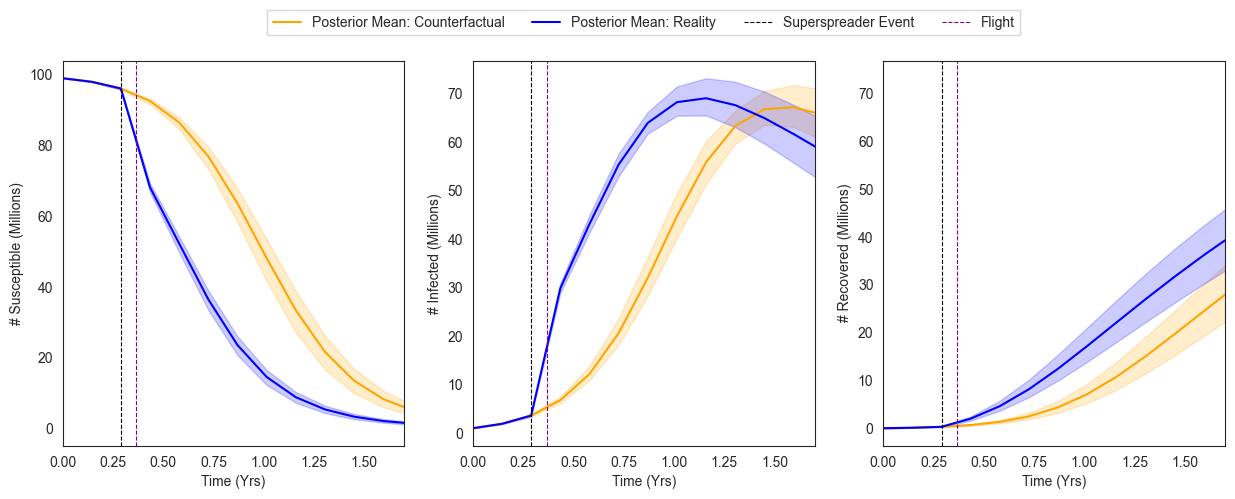

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_cf_uncertainty_plot(
    logging_times,
    cf_sir_posterior_samples['S_cf'].squeeze(),
    'Counterfactual',
    "# Susceptible (Millions)",
    "orange",
    ax=ax[0],
)

SIR_cf_uncertainty_plot(
    logging_times,
    cf_sir_posterior_samples['S_factual'].squeeze(),
    'Reality',
    "# Susceptible (Millions)",
    "blue",
    ax[0],
)

SIR_cf_uncertainty_plot(
    logging_times,
    cf_sir_posterior_samples['I_cf'].squeeze(),
    'Counterfactual',
    "# Infected (Millions)",
    "orange",
    ax=ax[1],
)

SIR_cf_uncertainty_plot(
    logging_times,
    cf_sir_posterior_samples['I_factual'].squeeze(),
    'Reality',
    "# Infected (Millions)",
    "blue",
    ax[1],
)

SIR_cf_uncertainty_plot(
    logging_times,
    cf_sir_posterior_samples['R_cf'].squeeze(),
    'Counterfactual',
    "# Recovered (Millions)",
    "orange",
    ax=ax[2],
)

SIR_cf_uncertainty_plot(
    logging_times,
    cf_sir_posterior_samples['R_factual'].squeeze(),
    'Reality',
    "# Recovered (Millions)",
    "blue",
    ax[2],
)

for ax_ in ax:
    ax_.axvline(superspreader_time, linestyle='--', color='black', label='Superspreader Event', linewidth=0.8)
    ax_.axvline(landing_time, linestyle='--', color='purple', label='Flight', linewidth=0.8)
    ax_.set_xlim((0, 1.7))
    ax_.legend()

ax[0].legend().remove()
ax[2].legend().remove()
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=False, shadow=False, ncol=4)


/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


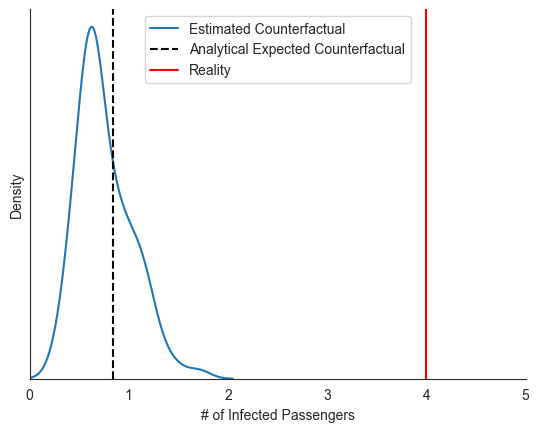

In [36]:
infected_pass_dist = cf_sir_posterior_samples['infected_passengers_0.36702409386634827'].squeeze()

sns.kdeplot(infected_pass_dist[:, 1], label='Estimated Counterfactual')
plt.axvline(x=true_cf_infected, color='black', label='Analytical Expected Counterfactual', linestyle='--')
plt.axvline(x=infected_pass_dist[:, 0].mean(), color='red', label='Reality')
plt.xlabel('# of Infected Passengers')
plt.yticks([])
plt.legend(loc='upper center')
plt.xlim(0, 5)
sns.despine()

## References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan
2. https://benjaminmoll.com/wp-content/uploads/2020/05/SIR_notes.pdf